# **Chapter 13 – Convolutional Neural Networks**

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from io import open

# Common imports
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Convolutional layer

In [4]:
from sklearn.datasets import load_sample_image
china=load_sample_image("china.jpg")
flower=load_sample_image("flower.jpg")

image = china[150:220, 130:250]
height, width, channels = image.shape
print(height)
print(width)
print(channels)
image_grayscale = image.mean(axis=2).astype(np.float32)  #在深度维度（通道）上求平均 70*120
print(image_grayscale.shape)
images = image_grayscale.reshape(1, height, width, 1)#是一个4维的数组
print(images.shape)

70
120
3
(70, 120)
(1, 70, 120, 1)


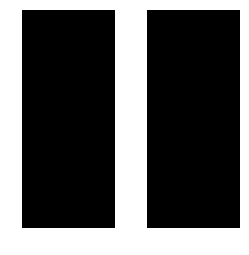

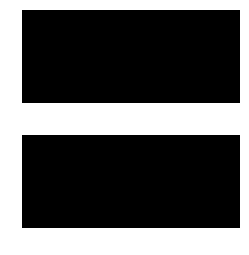

In [5]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)#7行7列的卷积核，通道为1，batch=2
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

Saving figure china_original


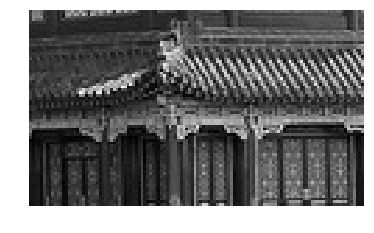

In [6]:
import tensorflow as tf
reset_graph()
X=tf.placeholder(tf.float32,shape=(None,height,width,1))
feature_map=tf.constant(fmap)
convolution=tf.nn.conv2d(X,feature_map,strides=[1,2,2,1],padding="SAME")
with tf.Session() as sess:
    output=sess.run(convolution,feed_dict={X:images})
    
plot_image(images[0, :, :, 0])
save_fig("china_original", tight_layout=False)
plt.show()

Saving figure china_vertical


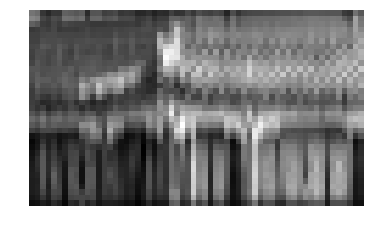

Saving figure china_horizontal


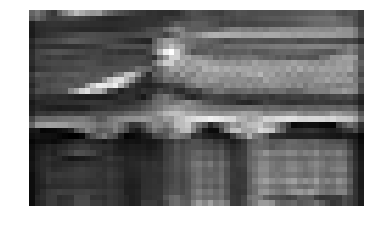

In [7]:
plot_image(output[0, :, :, 0])
save_fig("china_vertical", tight_layout=False)
plt.show()
plot_image(output[0, :, :, 1])
save_fig("china_horizontal", tight_layout=False)
plt.show()

## Sample Example

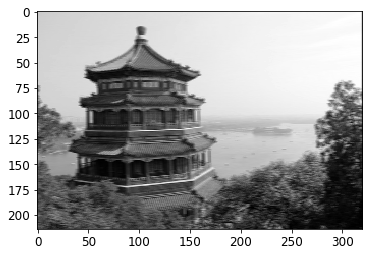

In [8]:
import numpy as np
from sklearn.datasets import load_sample_images

# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape      #(2, 427, 640, 3)

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset}) #(2, 214, 320, 2)

plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

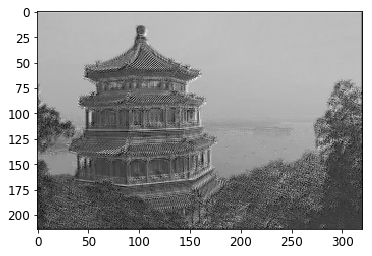

In [9]:
#tf.layers.conv2d与tf.nn.conv2d
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

## Pooling Layer

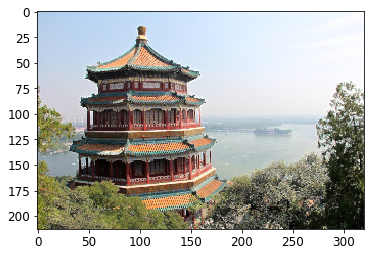

In [10]:
batch_size, height, width, channels = dataset.shape#(2, 427, 640, 3)
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line
X=tf.placeholder(tf.float32,shape=(None,height,width,channels))
max_pool=tf.nn.max_pool(X,ksize=[1,2,2,1],strides=[1,2,2,1],padding="VALID")
with tf.Session() as sess:
    output=sess.run(max_pool,feed_dict={X:dataset})
    
plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()

### MNIST

Note: we now use the dense(), conv2d() and dropout() functions (respectively) from the tf.layers module,  because  tf.layers is part of the official API.

For all these functions:
 the _fn suffix was removed in all the parameters that had it (for example the activation_fn parameter was renamed to activation).

The other main differences in tf.layers.dense() are:

the weights variable is now named `kernel` rather than "weights")
the default activation is `None` instead of tf.nn.relu

The other main differences in tf.layers.conv2d() are:

the num_outputs parameter was renamed to `filters`,
the stride parameter was renamed to `strides`,
the default activation is now `None` instead of tf.nn.relu.

The other main differences in tf.layers.dropout() are:

it takes the dropout `rate` rather than the keep probability (keep_prob). Of course, rate == 1 - keep_prob,
the is_training parameters was renamed to `training`.

In [11]:
height=28
width=28
channels = 1
n_inputs = height * width

conv1_fmaps = 32  #卷积核个数
conv1_ksize = 3   #卷积核宽高
conv1_stride = 1  #步幅
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = 64

n_fc1 = 64
n_outputs = 10


reset_graph()
with tf.name_scope("inputs"):
    X=tf.placeholder(tf.float32,shape=[None,n_inputs],name="X")
    X_reshaped=tf.reshape(X,shape=[-1,height,width,channels])
    y=tf.placeholder(tf.int32,shape=[None],name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")
with tf.name_scope("pool3"):
    pool3=tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding="VALID")
    pool3_flat=tf.reshape(pool3,shape=[-1,pool3_fmaps*7*7])     #卷积核个数*7*7，池化之后要把二维图像转化为一维列向量

with tf.name_scope("fc1"):
    fc1=tf.layers.dense(pool3_flat,n_fc1,activation=tf.nn.relu,name="fc1")#全链接，每个特征图的一维列向量均与64个神经元相连
    
with tf.name_scope("output"):
    logits=tf.layers.dense(fc1,n_outputs,name="output")
    Y_proba=tf.nn.softmax(logits,name="Y_proba")


with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)# 损失函数：计算交叉熵
    loss = tf.reduce_mean(xentropy)   #平均交叉熵
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [12]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [13]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [ ]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")